In [1]:
import os, sys
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, root)


In [2]:
from src import preprocess, training, diffe
import importlib

importlib.reload(preprocess)
importlib.reload(training)
importlib.reload(diffe)

<module 'src.diffe' from '/home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/diffe.py'>

In [26]:
train_ds, val_ds, test_ds = training.get_datasets(use_zscore=True, single_channel=True, scale_factor=3) # single_channel -> trenowanie na kanale 'Fp1'
train_loader, val_loader, test_loader = training.get_loaders(train_ds, val_ds, test_ds, num_workers=8)

/home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/training.py:78: RuntimeWarning: This filename (/home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/../data/preprocessed/sub-01_preprocessed_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path, preload=True, verbose=False)
/home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/training.py:78: RuntimeWarning: This filename (/home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/../data/preprocessed/sub-02_preprocessed_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path, preload=True, verbose=False)
/home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/training.py:78: RuntimeWarning: This filename (/home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/../data/p

In [24]:
import torch
from src.vaeeg import VAEEG
from src.globals import SEED

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 1e-3
num_epochs = 200
beta = 1e-3  # dostosowane do skali danych i błędu MSE

z_dim = 16
model16 = VAEEG(in_channels=1, z_dim=z_dim).to(device)
model16.load_state_dict(torch.load(f"../models/vaeeg/vaeeeg_model_latent_dim_{z_dim}.pt", map_location=device))
model16.eval()

z_dim = 32
model32 = VAEEG(in_channels=1, z_dim=z_dim).to(device)
model32.load_state_dict(torch.load(f"../models/vaeeg/vaeeeg_model_latent_dim_{z_dim}.pt", map_location=device))
model32.eval()

z_dim = 64
model64 = VAEEG(in_channels=1, z_dim=z_dim).to(device)
model64.load_state_dict(torch.load(f"../models/vaeeg/vaeeeg_model_latent_dim_{z_dim}.pt", map_location=device))
model64.eval()

z_dim = 128
model128 = VAEEG(in_channels=1, z_dim=z_dim).to(device)
model128.load_state_dict(torch.load(f"../models/vaeeg/vaeeeg_model_latent_dim_{z_dim}.pt", map_location=device))
model128.eval()

models = {"16": model16,
          '32': model32,
          '64': model64,
          '128': model128}


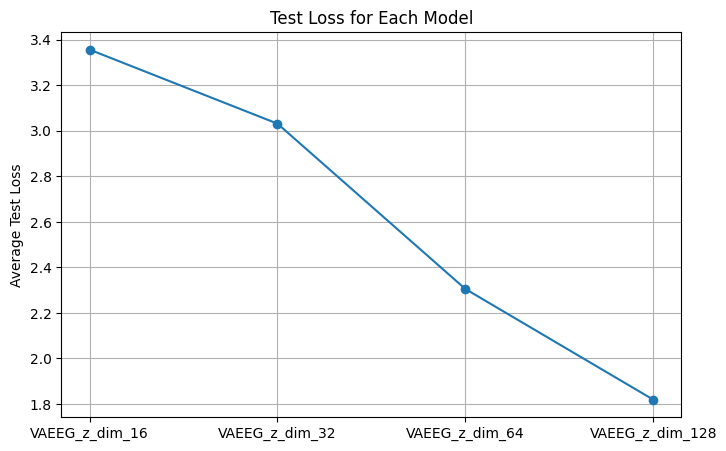

In [15]:
import matplotlib.pyplot as plt
from src.vaeeg import kl_loss, recon_loss

model_names = []
avg_losses = []

for key, model in models.items():
    torch.manual_seed(SEED)
    epoch_recon_loss = 0
    epoch_kl_loss = 0
    for x in test_loader:
        x = x.to(device)

        mu, log_var, x_bar = model(x)

        r_loss = recon_loss(x, x_bar)
        k_loss = kl_loss(mu, log_var)
        loss = r_loss + beta * k_loss


        epoch_recon_loss += r_loss.item()
        epoch_kl_loss += k_loss.item()

    loss = (epoch_recon_loss + epoch_kl_loss) / len(test_loader)

    model_names.append('VAEEG_z_dim_' + key)
    avg_losses.append(loss)

plt.figure(figsize=(8, 5))
plt.plot(model_names, avg_losses, marker='o')
plt.ylabel("Average Test Loss")
plt.title("Test Loss for Each Model")
plt.grid(True)
plt.show()


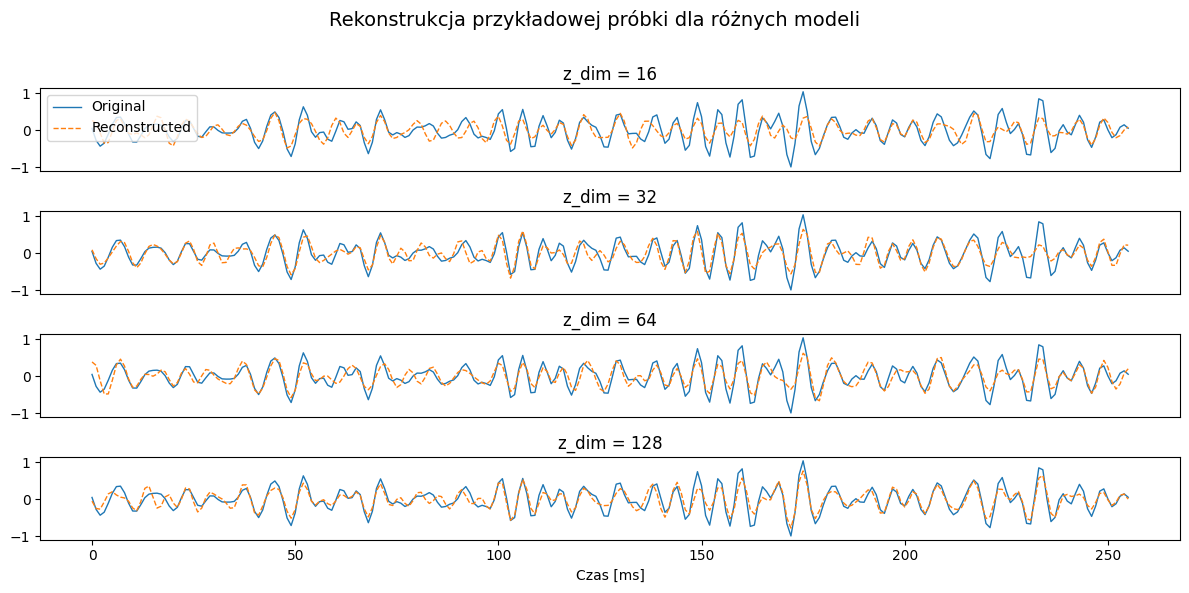

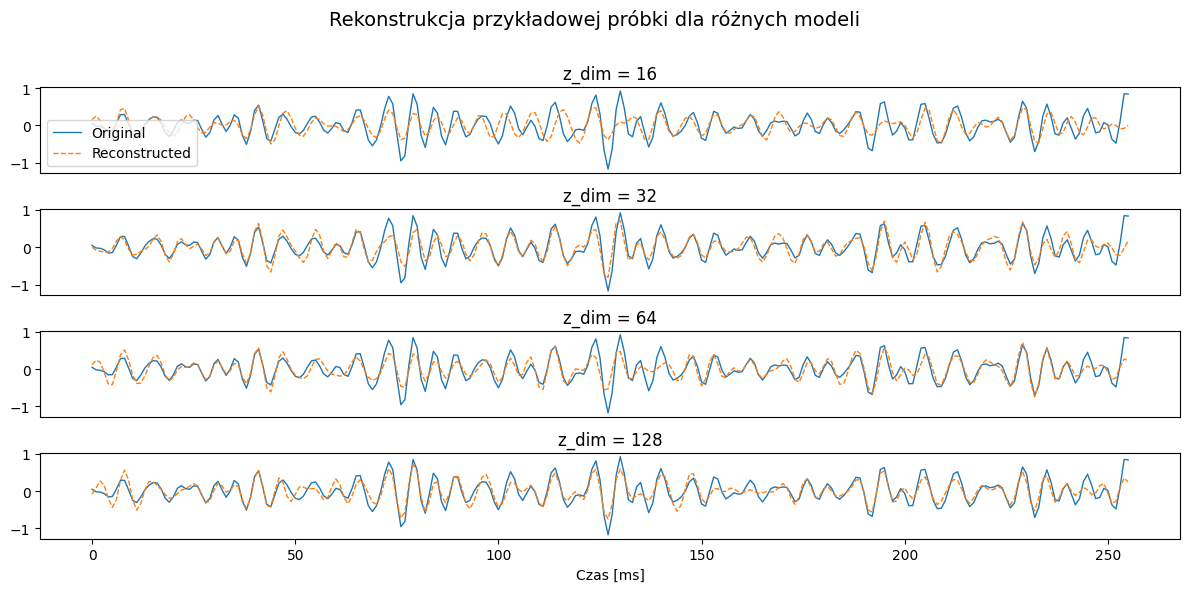

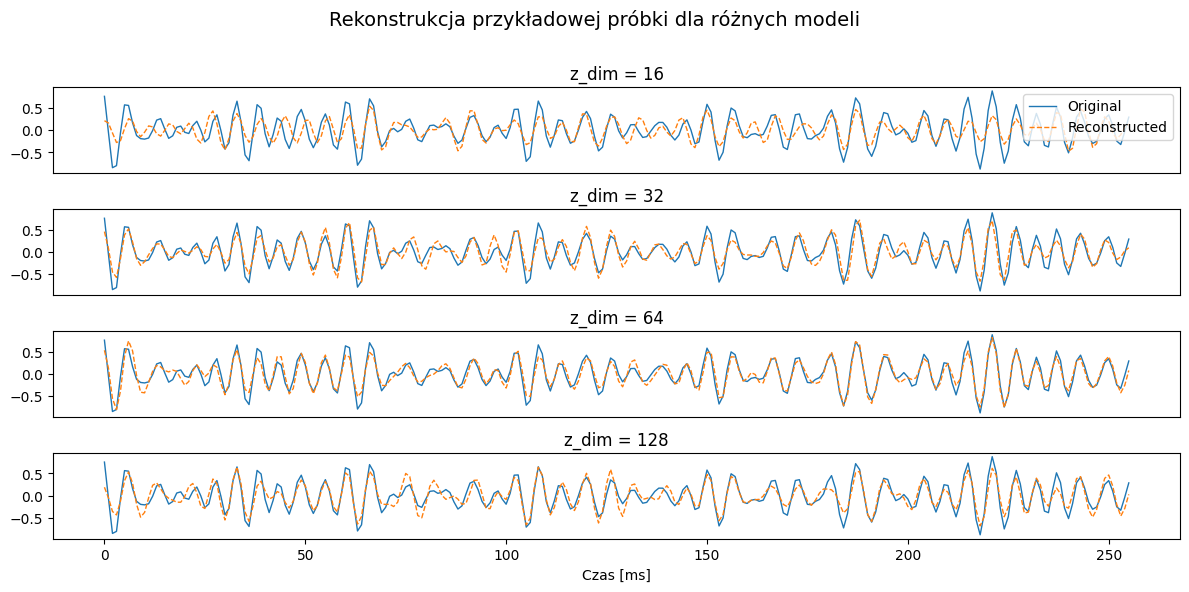

In [ ]:
import matplotlib.pyplot as plt
import torch
from src.vaeeg import kl_loss, recon_loss

torch.manual_seed(SEED)
x_batch = next(iter(test_loader))
x_batch = x_batch.to(device)

num_samples = 3

for i in range(num_samples):
    x_single = x_batch[i].unsqueeze(0) 

    fig, axs = plt.subplots(len(models), 1, figsize=(12 , 6))

    for idx, (key, model) in enumerate(models.items()):
        model.eval()
        with torch.no_grad():
            mu, log_var, x_recon = model(x_single)

        # Oryginał i rekonstrukcja
        original = x_single[0].detach().cpu().squeeze()
        recon = x_recon[0].detach().cpu().squeeze()

        axs[idx].plot(original, label='Original', linewidth=1)
        axs[idx].plot(recon, label='Reconstructed', linestyle='--', linewidth=1)

        axs[idx].set_title(f'z_dim = {key}')
        if idx != len(models) - 1:
            axs[idx].set_xticks([])
        else:
            axs[idx].set_xlabel("Czas [ms]")  # Dodaj opis osi X


    axs[0].legend()
    fig.suptitle("Rekonstrukcja przykładowej próbki dla różnych modeli", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


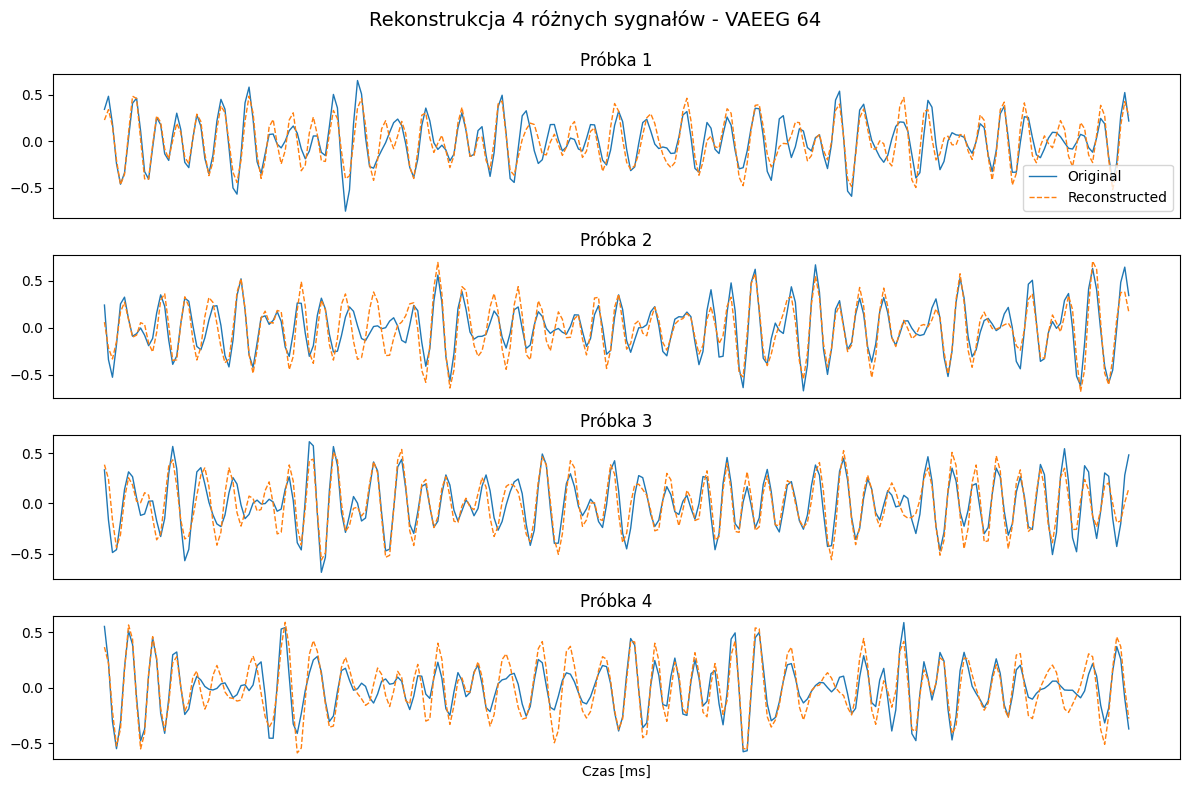

In [ ]:
import matplotlib.pyplot as plt
import torch

torch.manual_seed(SEED)
x_batch = next(iter(test_loader))
x_batch = x_batch.to(device)

model_key = "64"
model = models[model_key]
model.eval()

num_samples = 4  # Liczba sygnałów do pokazania

fig, axs = plt.subplots(num_samples, 1, figsize=(12, 8))

for i in range(num_samples):
    x_single = x_batch[i+4].unsqueeze(0) /3

    with torch.no_grad():
        mu, log_var, x_recon = model(x_single)

    original = x_single[0].detach().cpu().squeeze()
    recon = x_recon[0].detach().cpu().squeeze()

    axs[i].plot(original, label='Original', linewidth=1)
    axs[i].plot(recon, label='Reconstructed', linestyle='--', linewidth=1)
    axs[i].set_title(f"Próbka {i + 1}")
    axs[i].set_xticks([])

axs[-1].set_xlabel("Czas [ms]")
axs[0].legend()
fig.suptitle("Rekonstrukcja 4 różnych sygnałów - VAEEG 64", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


# PCA

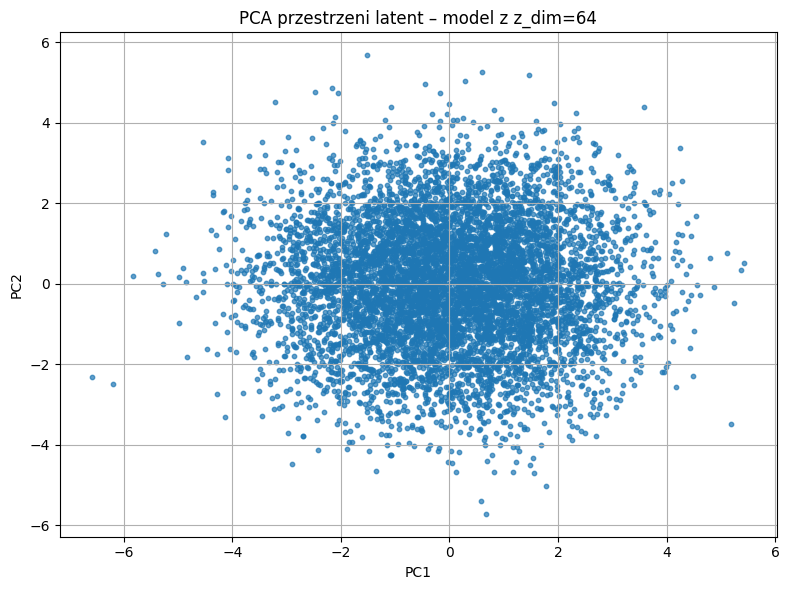

In [42]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Wybierz jeden model
model_key = "64"  # np. z_dim = 32
model = models[model_key]
model.eval()

latents = []
# n_batches = 10  # liczba batchy do pobrania z test_loader

with torch.no_grad():
    for i, x_batch in enumerate(test_loader):
        # if i >= n_batches:
            # break
        x_batch = x_batch.to(device)
        mu, log_var, _ = model(x_batch)  # Zakładam: model(x) → (mu, log_var, recon)
        latents.append(mu.cpu())

# Konkatenacja wszystkich latentów
latents = torch.cat(latents, dim=0)  # shape: [N, z_dim]

# PCA do 2D
pca = PCA(n_components=2)
latents_2d = pca.fit_transform(latents.numpy())

# Wykres
plt.figure(figsize=(8, 6))
plt.scatter(latents_2d[:, 0], latents_2d[:, 1], s=10, alpha=0.7)
plt.title(f"PCA przestrzeni latent – model z z_dim={model_key}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


# Metryki

In [40]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import math

def psnr(signal, recon, max_val=1.0):
    """Peak Signal-to-Noise Ratio"""
    mse = np.mean((signal - recon) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(max_val / math.sqrt(mse))

def nrmse(x, x_hat):
    """Normalized Root Mean Square Error"""
    rmse = np.sqrt(np.mean((x - x_hat) ** 2))
    denom = np.max(x) - np.min(x)
    if denom == 0:
        return np.nan  # lub 0, jeśli sygnał stały
    return rmse / denom

results = {}

normalize = True  # czy normalizować dane przed metrykami

for key, model in models.items():
    model.eval()
    all_mse, all_mae, all_psnr, all_corr, all_nrmse = [], [], [], [], []

    with torch.no_grad():
        for i, x_batch in enumerate(test_loader):

            x_batch = x_batch.to(device)
            _, _, x_recon = model(x_batch)

            x_batch = x_batch.detach().cpu().numpy()
            x_recon = x_recon.detach().cpu().numpy()

            for xb, xr in zip(x_batch, x_recon):  # po epokach
                for ch_orig, ch_rec in zip(xb, xr):  # po kanałach

                    if normalize:
                        ch_orig = (ch_orig - ch_orig.mean()) / (ch_orig.std() + 1e-8)
                        ch_rec = (ch_rec - ch_rec.mean()) / (ch_rec.std() + 1e-8)

                    mse = mean_squared_error(ch_orig, ch_rec)
                    mae = mean_absolute_error(ch_orig, ch_rec)
                    p = psnr(ch_orig, ch_rec)
                    corr, _ = pearsonr(ch_orig, ch_rec)
                    nrmse_val = nrmse(ch_orig, ch_rec)

                    all_mse.append(mse)
                    all_mae.append(mae)
                    all_psnr.append(p)
                    all_corr.append(corr)
                    all_nrmse.append(nrmse_val)

    # Statystyki
    results[key] = {
        'MSE': (np.mean(all_mse), np.std(all_mse)),
        'MAE': (np.mean(all_mae), np.std(all_mae)),
        'PSNR': (np.mean(all_psnr), np.std(all_psnr)),
        'PearsonR': (np.mean(all_corr), np.std(all_corr)),
        'NRMSE': ((np.mean(all_nrmse), np.std(all_nrmse)))

    }

# Wyświetlenie wyników
print("=== Porównanie jakości rekonstrukcji ===")
for key, metrics in results.items():
    print(f"\nModel z z_dim = {key}:")
    for metric, (mean, std) in metrics.items():
        print(f"  {metric}: {mean:.4f} ± {std:.4f}")


=== Porównanie jakości rekonstrukcji ===

Model z z_dim = 16:
  MSE: 0.5038 ± 0.0970
  MAE: 0.5659 ± 0.0528
  PSNR: 3.0545 ± 0.8129
  PearsonR: 0.7481 ± 0.0485
  NRMSE: 0.1245 ± 0.0168

Model z z_dim = 32:
  MSE: 0.2254 ± 0.0603
  MAE: 0.3714 ± 0.0441
  PSNR: 6.6027 ± 1.0543
  PearsonR: 0.8873 ± 0.0301
  NRMSE: 0.0828 ± 0.0115

Model z z_dim = 64:
  MSE: 0.2191 ± 0.0593
  MAE: 0.3670 ± 0.0445
  PSNR: 6.7289 ± 1.0629
  PearsonR: 0.8904 ± 0.0297
  NRMSE: 0.0816 ± 0.0114

Model z z_dim = 128:
  MSE: 0.2470 ± 0.0637
  MAE: 0.3905 ± 0.0455
  PSNR: 6.1980 ± 1.0194
  PearsonR: 0.8765 ± 0.0319
  NRMSE: 0.0868 ± 0.0124


# DDPM

In [9]:
importlib.reload(preprocess)
importlib.reload(training)
importlib.reload(diffe)
from src.diffe import DDPM, ConditionalUNet

torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
# in_channels = train_ds[0].shape[0]
# n_feat = 192
in_channels = 16
n_T = 1000
betas = (1e-6, 1e-2)
base_lr, lr = 9e-5, 1.5e-3
step_size = 150

trainer2 = training.DDPMTrainer(
    model=DDPM(
        nn_model=ConditionalUNet(in_channels=in_channels, n_feat=128).to(device),
        betas=betas,
        n_T=n_T,
        device=device     
    ).to(device),
    model_name="Default params"
)
trainer2.load_model(10)

trainer4 = training.DDPMTrainer(
    model=DDPM(
        nn_model=ConditionalUNet(in_channels=in_channels, n_feat=64).to(device),
        betas=betas,
        n_T=n_T,
        device=device,
    ).to(device),
    model_name="64 HIDDEN SIZE",
)
trainer4.load_model()

trainer3 = training.DDPMTrainer(
    model=DDPM(
        nn_model=ConditionalUNet(in_channels=in_channels, n_feat=192).to(device),
        betas=betas,
        n_T=n_T,
        device=device,
    ).to(device),
    model_name="192 HIDDEN SIZE",
)
trainer3.load_model()

trainers = {
    1: trainer2,
    2: trainer3,
    3: trainer4,
}

Loading model Default params from /home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/../models/Default params/10.pt
Loading model 64 HIDDEN SIZE from /home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/../models/64 HIDDEN SIZE/9.pt
Loading model 192 HIDDEN SIZE from /home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/../models/192 HIDDEN SIZE/10.pt


In [4]:
train_ds2, val_ds2, test_ds2 = training.get_datasets(use_zscore=True)

/home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/training.py:78: RuntimeWarning: This filename (/home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/../data/preprocessed/sub-01_preprocessed_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path, preload=True, verbose=False)
/home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/training.py:78: RuntimeWarning: This filename (/home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/../data/preprocessed/sub-02_preprocessed_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path, preload=True, verbose=False)
/home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/training.py:78: RuntimeWarning: This filename (/home/szymonst/Sztuczna_Inteligencja/Sem-1/pgm/mind-reader/src/../data/p

In [11]:
train_dl, val_dl, test_dl = training.get_loaders(train_ds2, val_ds2, test_ds2, num_workers=8)

In [5]:
ite = next(iter(test_dl))
ite.shape

torch.Size([32, 16, 256])

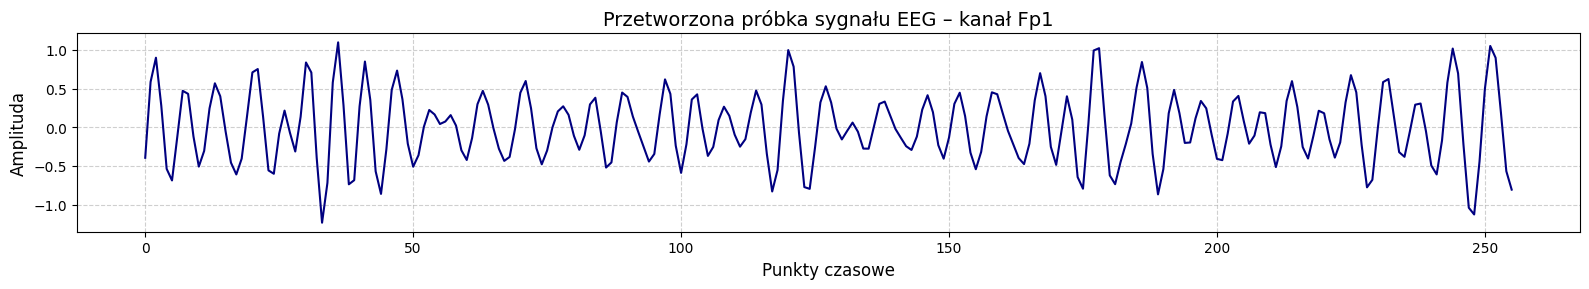

In [23]:
import matplotlib.pyplot as plt

# Pobierz pierwszy batch z dataloadera (iterujemy po train_dl)
batch = next(iter(train_dl))  # batch to (B, C, T)

# Wybierz pierwszy przykład i pierwszy kanał
signal = batch[0, 0, :].cpu().numpy()  # konwersja do numpy, jeśli na GPU

plt.figure(figsize=(16, 3))
plt.plot(signal, color='navy')

plt.title("Przetworzona próbka sygnału EEG – kanał Fp1", fontsize=14)
plt.xlabel("Punkty czasowe", fontsize=12)
plt.ylabel("Amplituda", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### jeden kanał!

In [20]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import math

def psnr(signal, recon, max_val=1.0):
    mse = np.mean((signal - recon) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(max_val / math.sqrt(mse))

def nrmse(x, x_hat):
    rmse = np.sqrt(np.mean((x - x_hat) ** 2))
    denom = np.max(x) - np.min(x)
    return rmse / denom if denom != 0 else np.nan

normalize = True
n_steps = 1000
ddpm_results = {}

for key, trainer in trainers.items():
    model = trainer.model
    model.eval()

    all_mse, all_mae, all_psnr, all_corr, all_nrmse = [], [], [], [], []

    with torch.no_grad():
        for x_batch in test_dl:
            x_batch = x_batch.to(device)

            # noise = torch.rand_like(x_batch)
            # samples, *_ = model.sample(noise, n_steps)
            x_fake, *_ = model(x_batch)
            # print(x_fake)
            # print(x_fake.shape)
            x_fake = x_fake.cpu().numpy()


            # Detach + CPU
            x_real = x_batch.detach().cpu().numpy()
            # x_fake = x_fake.detach().cpu().numpy()

            # x_real = x_batch.detach().cpu().numpy()
            # x_fake = samples.detach().cpu().numpy()

            for xb, xr in zip(x_real, x_fake):
                # break
                ch_orig = xb[0]  # tylko kanał 0
                ch_rec = xr[0]   # tylko kanał 0

                if normalize:
                    ch_orig = (ch_orig - ch_orig.mean()) / (ch_orig.std())
                    ch_rec = (ch_rec - ch_rec.mean()) / (ch_rec.std())

                mse = mean_squared_error(ch_orig, ch_rec)
                mae = mean_absolute_error(ch_orig, ch_rec)
                p = psnr(ch_orig, ch_rec)
                corr, _ = pearsonr(ch_orig, ch_rec)
                nrmse_val = nrmse(ch_orig, ch_rec)

                all_mse.append(mse)
                all_mae.append(mae)
                all_psnr.append(p)
                all_corr.append(corr)
                all_nrmse.append(nrmse_val)

    ddpm_results[trainer.model_name] = {
        'MSE': (np.mean(all_mse), np.std(all_mse)),
        'MAE': (np.mean(all_mae), np.std(all_mae)),
        'PSNR': (np.mean(all_psnr), np.std(all_psnr)),
        'PearsonR': (np.mean(all_corr), np.std(all_corr)),
        'NRMSE': (np.mean(all_nrmse), np.std(all_nrmse))
    }

print("=== DDPM: Jakość rekonstrukcji tylko dla kanału 0 ===")
for name, metrics in ddpm_results.items():
    print(f"\nModel: {name}")
    for metric, (mean, std) in metrics.items():
        print(f"  {metric}: {mean:.4f} ± {std:.4f}")


=== DDPM: Jakość rekonstrukcji tylko dla kanału 0 ===

Model: Default params
  MSE: 0.6989 ± 0.6283
  MAE: 0.5835 ± 0.3229
  PSNR: 4.4733 ± 6.0155
  PearsonR: 0.6505 ± 0.3142
  NRMSE: 0.1264 ± 0.0728

Model: 192 HIDDEN SIZE
  MSE: 0.7074 ± 0.6346
  MAE: 0.5858 ± 0.3272
  PSNR: 4.5048 ± 6.1530
  PearsonR: 0.6463 ± 0.3173
  NRMSE: 0.1268 ± 0.0734

Model: 64 HIDDEN SIZE
  MSE: 0.7129 ± 0.6349
  MAE: 0.5888 ± 0.3265
  PSNR: 4.4455 ± 6.1505
  PearsonR: 0.6436 ± 0.3174
  NRMSE: 0.1275 ± 0.0733


Reconstruction loss for 0: 0.754138708114624


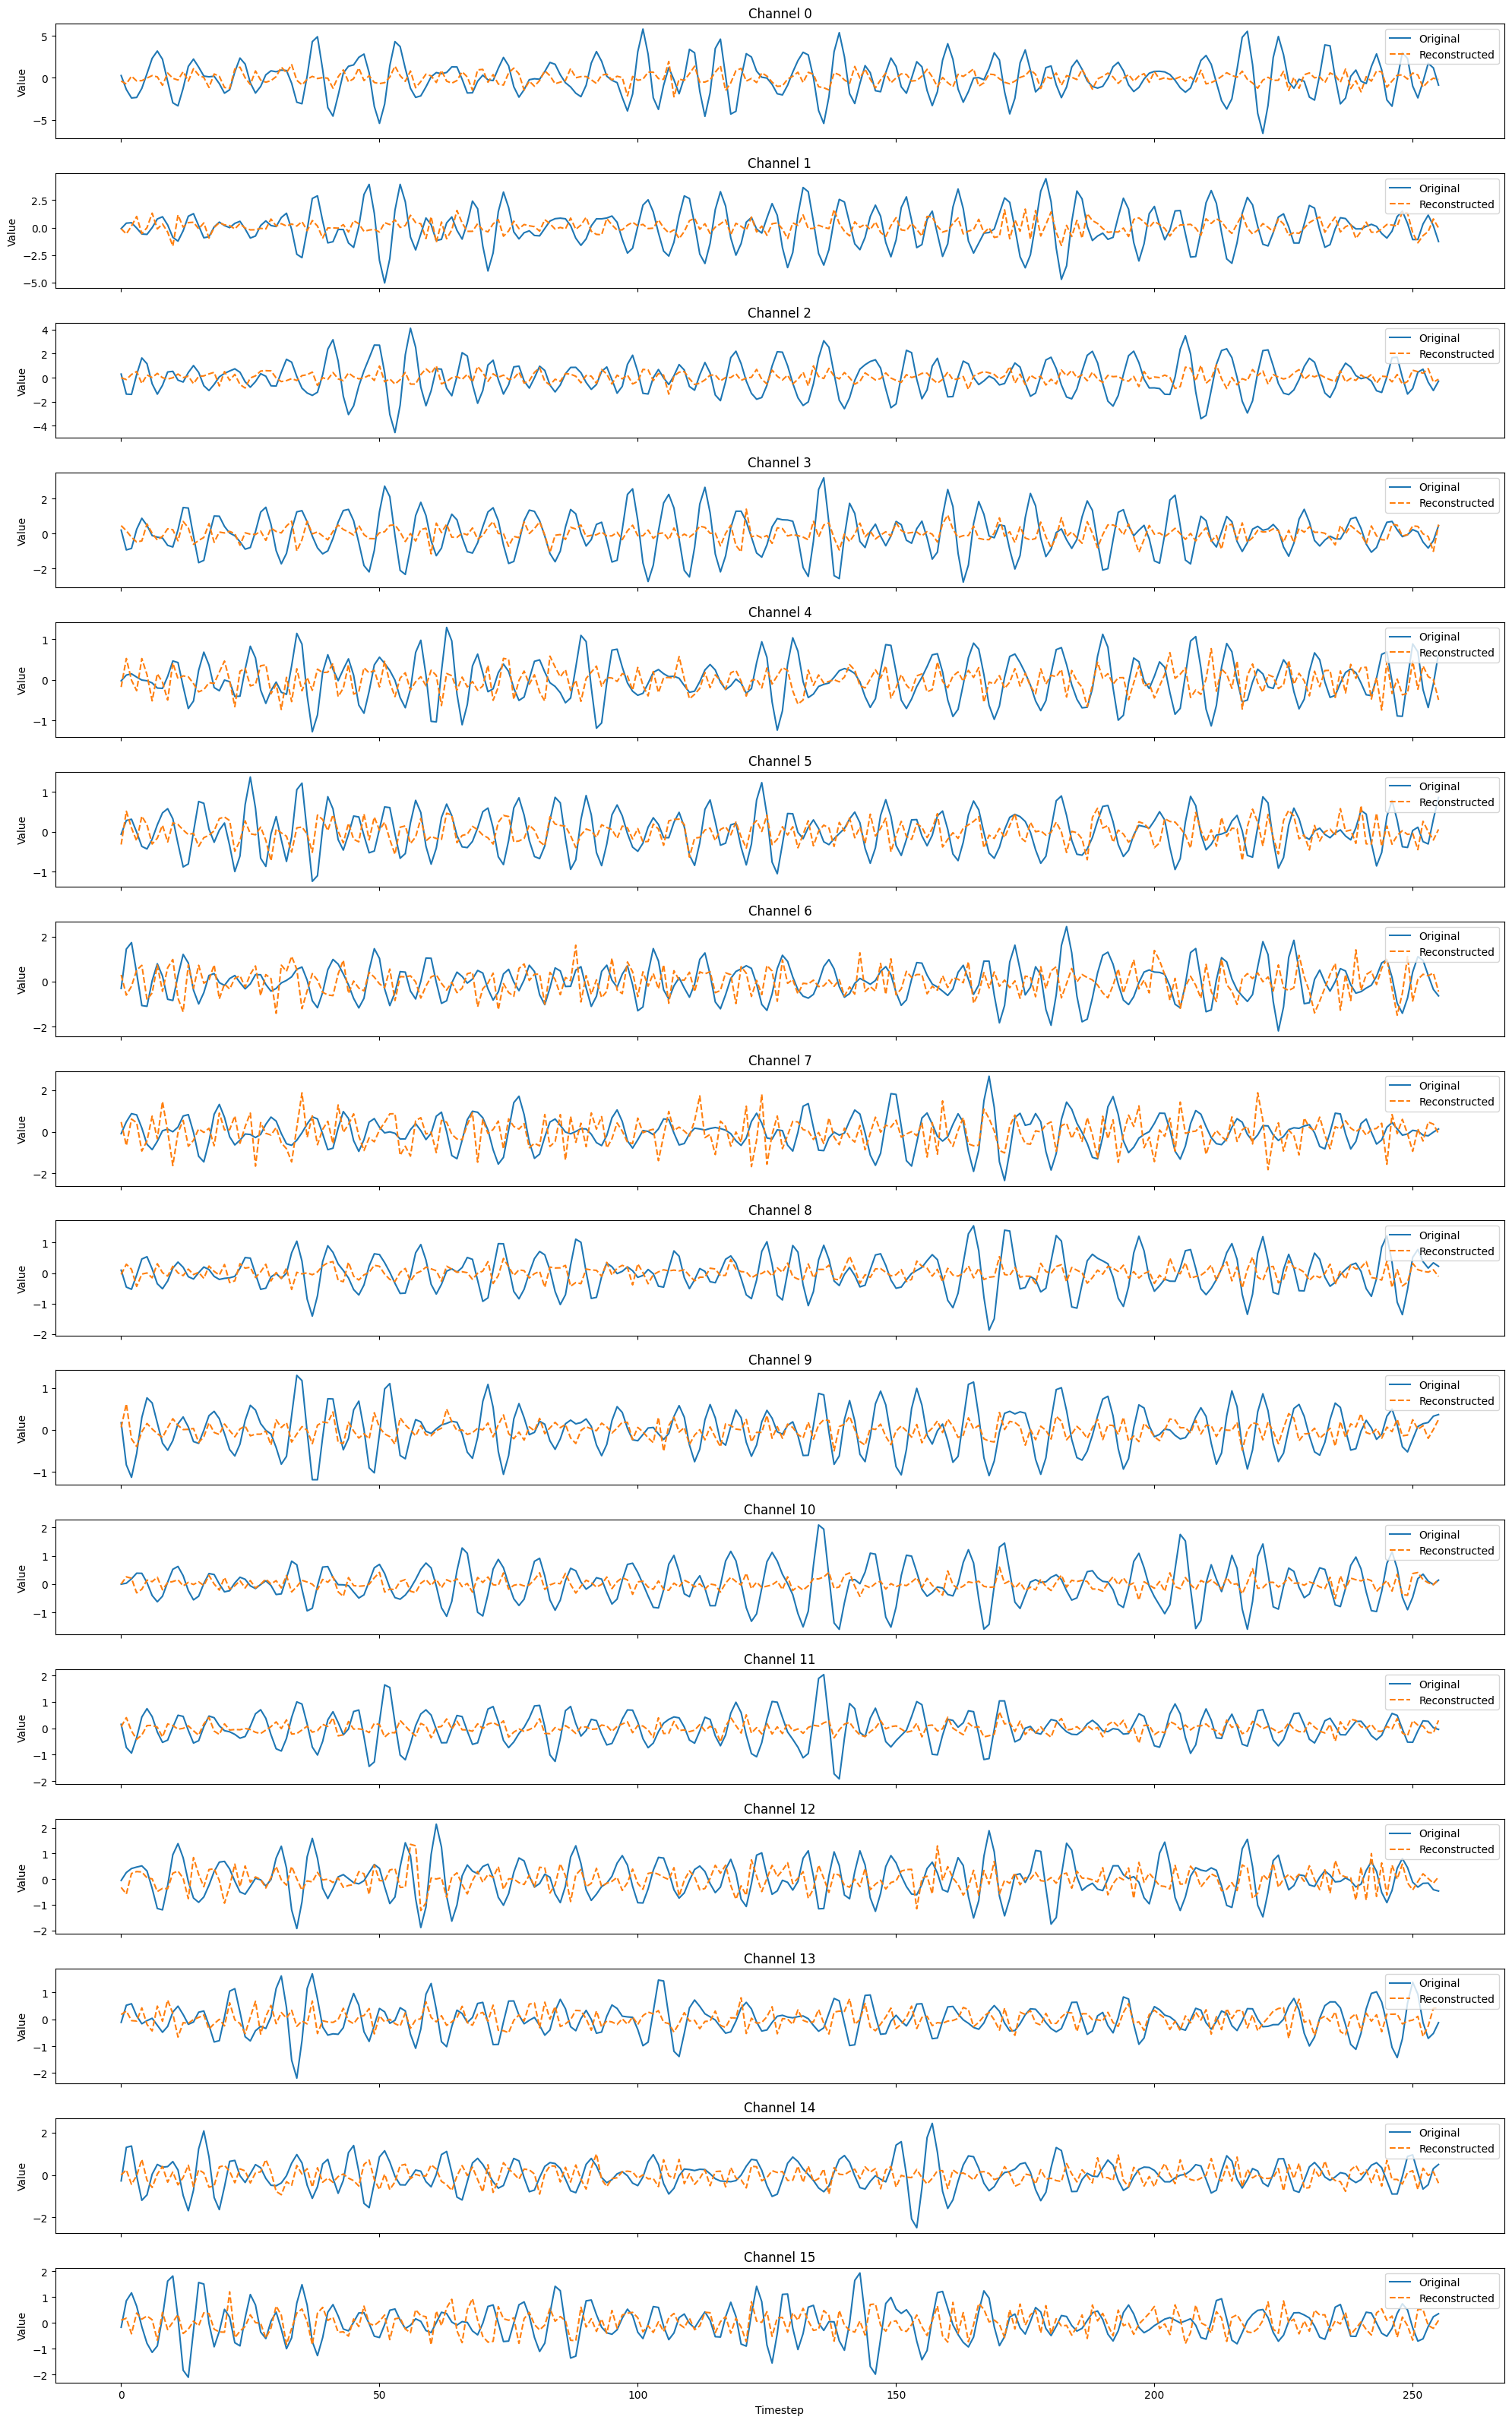

In [ ]:
import random

for random_np in range(32):
    x = (
        next(iter(test_dl)).to(device)[random_np].unsqueeze(0)
    ) 
    x_hat = trainer2.model(x)
    l1oss = torch.nn.L1Loss()
    x_hat = x_hat[0].squeeze(0)
    loss = l1oss(x_hat, x)
    print(f"Reconstruction loss for {random_np}: {loss.cpu().item()}")
    import matplotlib.pyplot as plt
    import numpy as np

    fig, axs = plt.subplots(16, 1, figsize=(20, 32), sharex=True)
    x_np = x.squeeze(0).detach().cpu().numpy()
    x_hat_np = x_hat.detach().cpu().numpy()
    for i in range(16):
        axs[i].plot(x_np[i], label='Original')
        axs[i].plot(x_hat_np[i], label='Reconstructed', linestyle='--')
        axs[i].set_title(f'Channel {i}')
        axs[i].legend(loc='upper right')
        axs[i].set_ylabel('Value')
    axs[-1].set_xlabel('Timestep')
    plt.tight_layout()
    plt.show()
    s = input("Press Enter to continue to the next sample...")
    plt.clf()
    plt.close(fig)

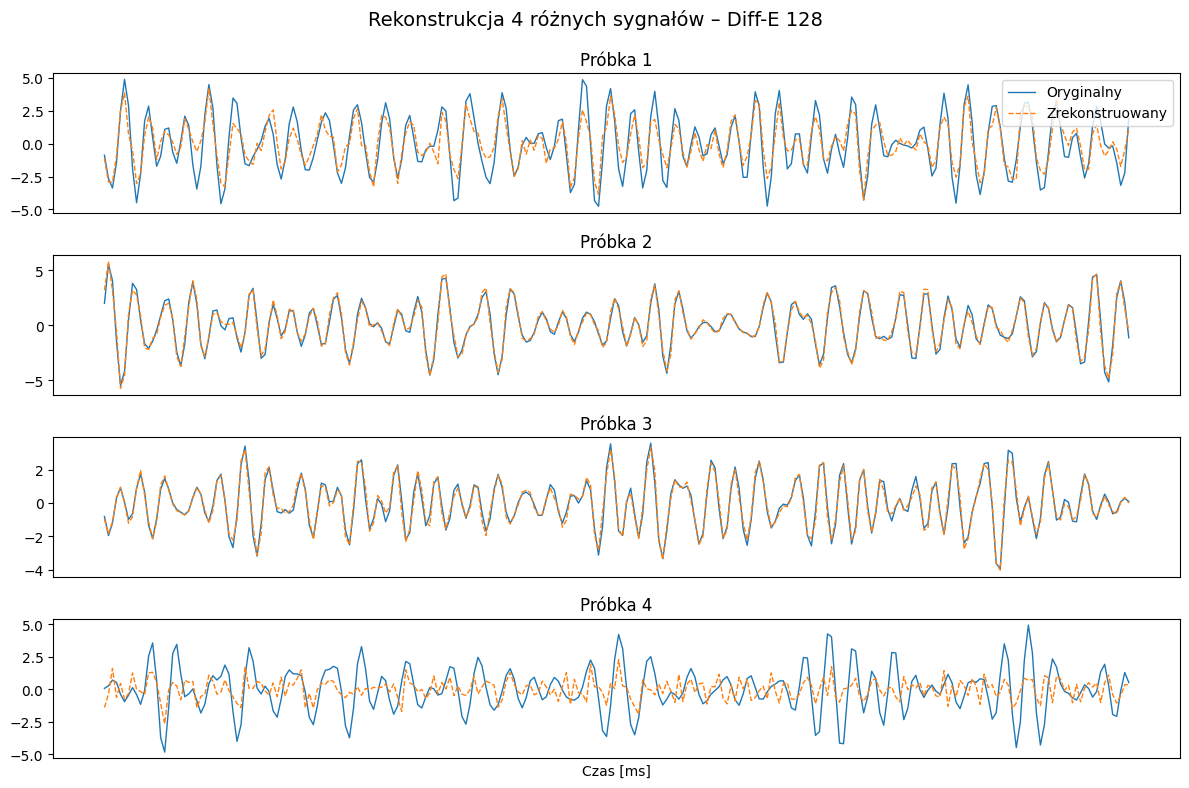

: 

In [ ]:
import matplotlib.pyplot as plt
import torch

# Założenie: masz wcześniej zdefiniowane: SEED, test_dl, trainers, device
torch.manual_seed(SEED)

# Wybierz model do wizualizacji – np. pierwszy z `trainers`
model_key = list(trainers.keys())[0]
trainer = trainers[model_key]
model = trainer.model
model.eval()

# Pobierz jedną paczkę danych testowych
x_batch = next(iter(test_dl)).to(device)

num_samples = 4  # Liczba sygnałów do pokazania
fig, axs = plt.subplots(num_samples, 1, figsize=(12, 8))

with torch.no_grad():
    x_fake, *_ = model(x_batch)
    x_real = x_batch.detach().cpu()
    x_fake = x_fake.detach().cpu()

shift = 22
for i in range(num_samples):
    ch_real = x_real[i+ shift, 0]  # Kanał 0
    ch_fake = x_fake[i+ shift, 0]  # Kanał 0

    axs[i].plot(ch_real, label='Oryginalny', linewidth=1)
    axs[i].plot(ch_fake, label='Zrekonstruowany', linestyle='--', linewidth=1)
    axs[i].set_title(f"Próbka {i + 1}")
    axs[i].set_xticks([])

axs[-1].set_xlabel("Czas [ms]")
axs[0].legend()
fig.suptitle(f"Rekonstrukcja 4 różnych sygnałów – Diff-E 128", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
